# Use notebook to display everthing that requires HTML

In [1]:
import pandas as pd

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category = FutureWarning)
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category = FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (
    count,
    selection_rate,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
)
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import EqualizedOdds
from sklearn.model_selection import train_test_split
import warnings

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn import tree

warnings.simplefilter("ignore")

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

rand_seed = 1234
np.random.seed(rand_seed)

import helper_func as f

####### Load Dataset #######
df = pd.read_csv('heart.csv', header = 0)
df.columns = ['Age','Sex','ChestPainType','RestingBP','Cholesterol','FastingBS','RestingECG','MaxHR','ExerciseAngina','Oldpeak','ST_Slope','HeartDisease']

df['Sex'] = df.Sex.map({'F': 2, 'M': 1})
Y, A = df.loc[:, "HeartDisease"], df.loc[:, "Sex"]
X = pd.get_dummies(df.drop(columns=["HeartDisease", "Sex"]), dtype = float)

A_str = A.map({1: "male", 2: "female"})
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, Y, A_str, test_size=0.2, stratify=Y
)

X_train, y_train, A_train = f.resample_training_data(X_train, y_train, A_train)


## SHAP

### Support Vector Machine

In [2]:
import sklearn
import shap
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# print the JS visualization code to the notebook
shap.initjs()

# train a SVM classifier
classifier = SVC(kernel = 'linear', probability=True)
classifier.fit(X_train, y_train)

train_pred = classifier.predict(X_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)


cm_test = confusion_matrix(y_pred, y_test)
cm_train = confusion_matrix(train_pred, y_train)

print("SVM linear:    Training accuracy: {:.2f}% | Test accuracy: {:.2f}% | F1 score: {:.3f}".format(accuracy_score(train_pred, y_train)*100, 
                                                                                  accuracy_score(y_pred, y_test)*100, 
                                                                                  f1_score(y_pred, y_test))) 
print("Coefficients:", classifier.coef_)
print("Train Confusion matrix", cm_train.ravel(), "| Test Confusion Matrix", cm_test.ravel())



SVM linear:    Training accuracy: 88.18% | Test accuracy: 87.50% | F1 score: 0.887
Coefficients: [[ 0.0079217  -0.00154392 -0.00273039  1.06563366 -0.01038865  0.24272633
   0.74918718 -0.27647134 -0.53969469  0.06697885 -0.07089771  0.05609491
   0.01480281 -0.50960214  0.50960214 -0.35867553  1.00941999 -0.65074446]]
Train Confusion matrix [359  49  47 357] | Test Confusion Matrix [71 12 11 90]


In [3]:
# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(classifier.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)

# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")

Using 812 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 184/184 [03:59<00:00,  1.30s/it]


In [4]:
# plot the SHAP values for the Setosa output of all instances
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, link="logit")

### Naive Bayes

In [25]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

train_pred = classifier.predict(X_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_pred, y_test)
cm_train = confusion_matrix(train_pred, y_train)

print("Naive Bayes:   Training accuracy: {:.2f}% | Test accuracy: {:.2f}% | F1 score: {:.3f}".format(accuracy_score(train_pred, y_train)*100, 
                                                                                  accuracy_score(y_pred, y_test)*100, 
                                                                                  f1_score(y_pred, y_test))) 
print("Train Confusion matrix", cm_train.ravel(), "| Test Confusion Matrix", cm_test.ravel())

Naive Bayes:   Training accuracy: 85.84% | Test accuracy: 85.33% | F1 score: 0.866
Train Confusion matrix [344  53  62 353] | Test Confusion Matrix [70 15 12 87]


In [26]:
# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(classifier.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)

# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")

Using 812 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 184/184 [02:18<00:00,  1.32it/s]


In [27]:
# plot the SHAP values for the Setosa output of all instances
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, link="logit")

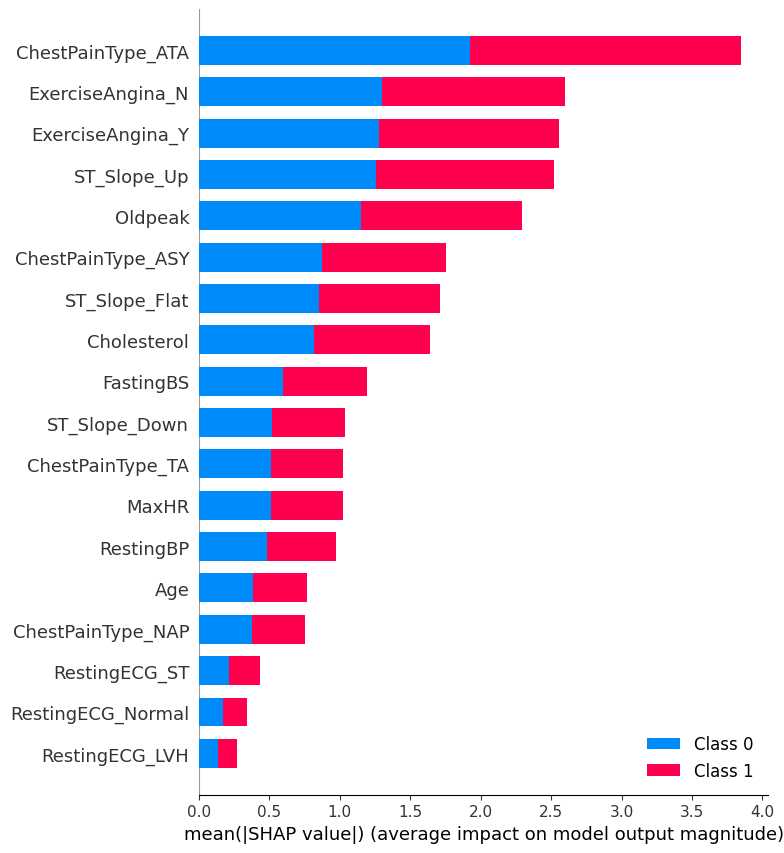

<Figure size 640x480 with 0 Axes>

In [31]:
%matplotlib inline
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [18]:
print(shap_values[0][0,:])

[ 0.          0.01822036  0.21058806  0.2887311   0.          0.25496087
  0.62607121  0.          0.33897013  0.03726302  0.         -0.07840677
 -0.05787619  0.15547281  0.21396872  0.          0.64384925  0.64029089]


### Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

train_pred = classifier.predict(X_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

print("Logistic Regression:Training accuracy: {:.2f}% | Test accuracy: {:.2f}% | F1 score: {:.3f}".format(accuracy_score(train_pred, y_train)*100, 
                                                                                  accuracy_score(y_pred, y_test)*100, 
                                                                                  f1_score(y_pred, y_test))) 

cm_test = confusion_matrix(y_pred, y_test)
cm_train = confusion_matrix(train_pred, y_train)
print("Train Confusion matrix", cm_train.ravel(), "| Test Confusion Matrix", cm_test.ravel())

Logistic Regression:Training accuracy: 88.67% | Test accuracy: 85.33% | F1 score: 0.864
Train Confusion matrix [362  48  44 358] | Test Confusion Matrix [71 16 11 86]


In [33]:
# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(classifier.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)

# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")

Using 812 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 184/184 [02:21<00:00,  1.30it/s]


In [34]:
# plot the SHAP values for the Setosa output of all instances
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, link="logit")

In [ ]:
shap.decision_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link = 'logit')

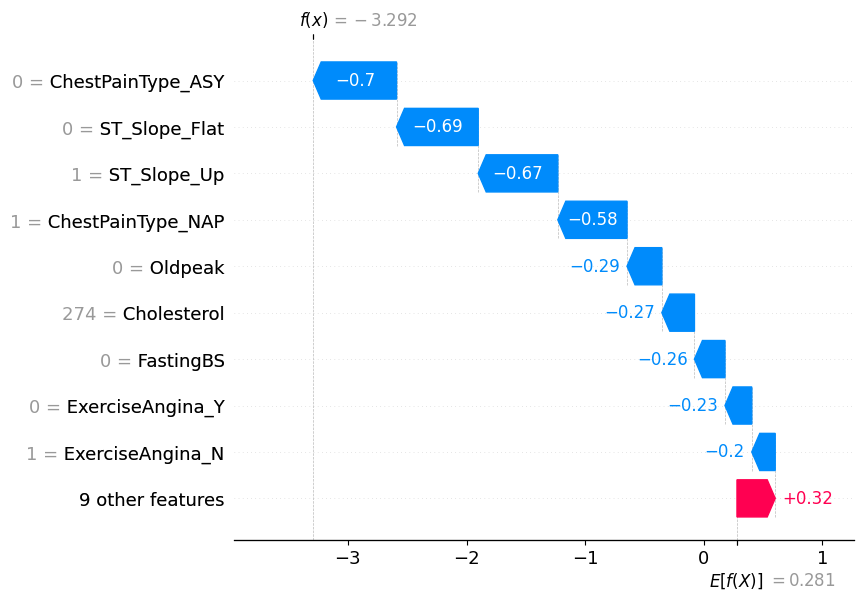

In [24]:
classifier.fit(X_train, y_train)

masker = shap.maskers.Independent(data=X_test)

explainer = shap.Explainer(
    classifier, masker=masker, feature_names=X_train.columns, algorithm="linear"
)

sv = explainer(X_test)
# visualize the first prediction's explanation
shap.plots.waterfall(sv[0])
plt.show()

## InterpretML

In [ ]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

In [ ]:
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

auc = roc_auc_score(y_test, ebm.predict_proba(X_test)[:, 1])
print("AUC: {:.3f}".format(auc))

show(ebm.explain_global())